In [ ]:
# script for asisinfs asnd RGB and user denfined avg for images.

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom

ct_scan_path = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/111222000/111222000_sample_0.npy"
heatmaps_folder = "/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222000/"

heatmap_files = {
    "left":    "111222000_sample_0_token_1_left_heatmaps.npy",
    "severe":  "111222000_sample_0_token_2_severe_heatmaps.npy",
    "consolidation": "111222000_sample_0_token_3_consolidation_heatmaps.npy",
}

token_rgb = {
    "left": (1.0, 0.0, 0.0),    
    "severe": (0.0, 1.0, 0.0),  
    "consolidation": (0.0, 0.0, 1.0), 
}

ct_volume = np.load(ct_scan_path)  # Shape: (1, 1, 64, 64, 64)
ct_slices = ct_volume[0, 0, :, :, :]  # Shape: (64, 64, 64)

def resize_heatmap(heatmap, target_shape=(64, 64, 64)):
    zoom_factors = (
        target_shape[0] / heatmap.shape[0],
        target_shape[1] / heatmap.shape[1],
        target_shape[2] / heatmap.shape[2],
    )
    return zoom(heatmap, zoom_factors, order=1)

# === SETTINGS ===
# selected_tokens = ["consolidation"]
selected_tokens = ["severe", "consolidation"]
# selected_tokens = ["left", "severe", "consolidation"]
# selected_tokens = ["right", "pleural", "effusion"]
# selected_tokens = ["right"]  # You can also use ["right", "pleural", "effusion"]
#selected_tokens = ["pleural"] 
#selected_tokens = ["effusion"] 
# selected_tokens = ["pleural", "effusion"] 
# heatmap_threshold = 0.025  
heatmap_thresholds = {
    "left": 0.012,
    "severe": 0.0250,
    "consolidation": 0.011
}     

heatmaps_per_token = {}
for token in selected_tokens:
    heatmap_path = os.path.join(heatmaps_folder, heatmap_files[token])
    if not os.path.exists(heatmap_path):
        print(f"Missing heatmap: {heatmap_path}")
        continue

    heatmap_data = np.load(heatmap_path)  # Example: shape (64, 8, 8)
    resized = resize_heatmap(heatmap_data, target_shape=(64, 64, 64))  # Now (64, 64, 64)
    heatmaps_per_token[token] = resized

def overlay_colored_heatmaps_on_ct(ct_scan, heatmap_dict, title):
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(64):
        ct_slice = ct_scan[i, :, :]
        ct_norm = (ct_slice - np.min(ct_slice)) / (np.max(ct_slice) - np.min(ct_slice) + 1e-8)
        ct_rgb = np.stack([ct_norm] * 3, axis=-1)         # Shape: (64, 64, 3)
        ct_rgb = np.flipud(ct_rgb)             # Flip for medical view
        overlay_rgb = ct_rgb.copy()                       # This will be updated with color

        for token, heatmap in heatmap_dict.items():
            heatmap_slice = np.fliplr(heatmap[i, :, :])
            threshold = heatmap_thresholds[token]
            mask = heatmap_slice <= threshold
            # mask = heatmap_slice <= heatmap_threshold   super hack so image quality, 
            masked = heatmap_slice * mask                

            if np.any(mask):
                # Normalize only within the masked low-activation region
                min_val = np.min(masked[mask])
                max_val = np.max(masked[mask])
                if max_val - min_val < 1e-6:
                    normed = np.zeros_like(masked)
                else:
                    normed = (masked - min_val) / (max_val - min_val + 1e-8)

                r, g, b = token_rgb[token]
                for c, color_val in enumerate([r, g, b]):
                    overlay_channel = overlay_rgb[:, :, c]
                    overlay_channel[mask] = (
                        0.6 * overlay_channel[mask] + 0.4 * color_val * normed[mask]
                    )
                    overlay_rgb[:, :, c] = overlay_channel

        axes[i].imshow(overlay_rgb)
        axes[i].set_title(f"Slice {i}", fontsize=8)
        axes[i].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

overlay_colored_heatmaps_on_ct(
    ct_slices,
    heatmaps_per_token,
    title=f"Multi-Token Colored Overlay: {', '.join(selected_tokens)}"
)


In [ ]:
#script for full average
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom

ct_scan_path = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/222333444/222333444_sample_0.npy"
heatmaps_folder = "/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/222333444/"
heatmap_files = {
    "right":    "222333444_sample_0_token_1_right_heatmaps.npy",
    "pleural":  "222333444_sample_0_token_2_pleural_heatmaps.npy",
    "effusion": "222333444_sample_0_token_3_effusion_heatmaps.npy",
}

token_rgb = {
    "right": (1.0, 0.0, 0.0),      # Red
    "pleural": (0.0, 1.0, 0.0),    # Green
    "effusion": (0.0, 0.0, 1.0),   # Blue
}

ct_volume = np.load(ct_scan_path)  # Shape: (1, 1, 64, 64, 64)
ct_slices = ct_volume[0, 0, :, :, :]  # Shape: (64, 64, 64)

def resize_heatmap(heatmap, target_shape=(64, 64, 64)):
    zoom_factors = (
        target_shape[0] / heatmap.shape[0],
        target_shape[1] / heatmap.shape[1],
        target_shape[2] / heatmap.shape[2],
    )
    return zoom(heatmap, zoom_factors, order=1)

selected_tokens = ["right"]
#selected_tokens = ["effusion"]
#selected_tokens = ["pleural"]
#selected_tokens = ["right", "pleural", "effusion"]

heatmap_thresholds = {
    "right": 0.018,
    "pleural": 0.0210,
    "effusion": 0.05
}   

heatmaps_per_token = {}
for token in selected_tokens:
    heatmap_path = os.path.join(heatmaps_folder, heatmap_files[token])
    if not os.path.exists(heatmap_path):
        print(f"Missing heatmap: {heatmap_path}")
        continue

    heatmap_data = np.load(heatmap_path)
    resized = resize_heatmap(heatmap_data, target_shape=(64, 64, 64))
    heatmaps_per_token[token] = resized

def overlay_intersected_heatmaps_on_ct(ct_scan, heatmap_dict, title):
    intersected_slices = []

    for i in range(64):
        ct_slice = ct_scan[i, :, :]
        ct_norm = (ct_slice - np.min(ct_slice)) / (np.max(ct_slice) - np.min(ct_slice) + 1e-8)
        ct_rgb = np.stack([ct_norm] * 3, axis=-1)
        ct_rgb = np.flipud(ct_rgb)
        overlay_rgb = ct_rgb.copy()

        token_masks = []
        token_normed = []

        for token in heatmap_dict:
            heatmap_slice = np.fliplr(heatmap_dict[token][i, :, :])
            threshold = heatmap_thresholds[token]
            mask = heatmap_slice <= threshold
            masked = heatmap_slice * mask

            if np.any(mask):
                min_val = np.min(masked[mask])
                max_val = np.max(masked[mask])
                normed = (masked - min_val) / (max_val - min_val + 1e-8) if max_val - min_val > 1e-6 else np.zeros_like(masked)
            else:
                normed = np.zeros_like(masked)

            token_masks.append(mask)
            token_normed.append(normed)

        if token_masks:
            intersect_mask = np.logical_and.reduce(token_masks)
            if np.any(intersect_mask):
                for token, normed in zip(selected_tokens, token_normed):
                    r, g, b = token_rgb[token]
                    for c, color_val in enumerate([r, g, b]):
                        overlay_channel = overlay_rgb[:, :, c]
                        overlay_channel[intersect_mask] = (
                            0.6 * overlay_channel[intersect_mask] + 0.4 * color_val * normed[intersect_mask]
                        )
                        overlay_rgb[:, :, c] = overlay_channel
                intersected_slices.append((i, overlay_rgb))

    # Plot only intersected slices
    n = len(intersected_slices)
    cols = 8
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for ax in axes:
        ax.axis("off")

    for idx, (slice_idx, overlay) in enumerate(intersected_slices):
        axes[idx].imshow(overlay)
        axes[idx].set_title(f"Slice {slice_idx}", fontsize=8)
        axes[idx].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

overlay_intersected_heatmaps_on_ct(
    ct_slices,
    heatmaps_per_token,
    title=f"Token Intersection (Only Slices with Overlap): {', '.join(selected_tokens)}"
)


In [ ]:
# or it could be this one, test this as you go

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom

ct_scan_path = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/222333444/222333444_sample_0.npy"
heatmaps_folder = "/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/222333444/"

heatmap_files = {
    "right":    "222333444_sample_0_token_1_right_heatmaps.npy",
    "pleural":  "222333444_sample_0_token_2_pleural_heatmaps.npy",
    "effusion": "222333444_sample_0_token_3_effusion_heatmaps.npy",
}


token_rgb = {
    "right": (1.0, 0.0, 0.0),      # Red
    "pleural": (0.0, 1.0, 0.0),    # Green
    "effusion": (0.0, 0.0, 1.0),   # Blue
}

ct_volume = np.load(ct_scan_path)  # Shape: (1, 1, 64, 64, 64)
ct_slices = ct_volume[0, 0, :, :, :]  # Shape: (64, 64, 64)

def resize_heatmap(heatmap, target_shape=(64, 64, 64)):
    zoom_factors = (
        target_shape[0] / heatmap.shape[0],
        target_shape[1] / heatmap.shape[1],
        target_shape[2] / heatmap.shape[2],
    )
    return zoom(heatmap, zoom_factors, order=1)

selected_tokens = ["right"]
#selected_tokens = ["effusion"]
#selected_tokens = ["pleural"]
#selected_tokens = ["right", "pleural", "effusion"]

heatmap_thresholds = {
    "right": 0.018,
    "pleural": 0.0210,
    "effusion": 0.05
}   

heatmaps_per_token = {}
for token in selected_tokens:
    heatmap_path = os.path.join(heatmaps_folder, heatmap_files[token])
    if not os.path.exists(heatmap_path):
        print(f"Missing heatmap: {heatmap_path}")
        continue

    heatmap_data = np.load(heatmap_path)
    resized = resize_heatmap(heatmap_data, target_shape=(64, 64, 64))
    heatmaps_per_token[token] = resized

def overlay_intersected_heatmaps_on_ct(ct_scan, heatmap_dict, title):
    intersected_slices = []

    for i in range(64):
        ct_slice = ct_scan[i, :, :]
        ct_norm = (ct_slice - np.min(ct_slice)) / (np.max(ct_slice) - np.min(ct_slice) + 1e-8)
        ct_rgb = np.stack([ct_norm] * 3, axis=-1)
        ct_rgb = np.flipud(ct_rgb)
        overlay_rgb = ct_rgb.copy()

        token_masks = []
        token_normed = []

        for token in heatmap_dict:
            heatmap_slice = np.fliplr(heatmap_dict[token][i, :, :])
            threshold = heatmap_thresholds[token]
            mask = heatmap_slice <= threshold
            masked = heatmap_slice * mask

            if np.any(mask):
                min_val = np.min(masked[mask])
                max_val = np.max(masked[mask])
                normed = (masked - min_val) / (max_val - min_val + 1e-8) if max_val - min_val > 1e-6 else np.zeros_like(masked)
            else:
                normed = np.zeros_like(masked)

            token_masks.append(mask)
            token_normed.append(normed)

        # Intersect all token masks
        if token_masks:
            intersect_mask = np.logical_and.reduce(token_masks)
            if np.any(intersect_mask):
                for token, normed in zip(selected_tokens, token_normed):
                    r, g, b = token_rgb[token]
                    for c, color_val in enumerate([r, g, b]):
                        overlay_channel = overlay_rgb[:, :, c]
                        overlay_channel[intersect_mask] = (
                            0.6 * overlay_channel[intersect_mask] + 0.4 * color_val * normed[intersect_mask]
                        )
                        overlay_rgb[:, :, c] = overlay_channel
                intersected_slices.append((i, overlay_rgb))

    # Plot only intersected slices
    n = len(intersected_slices)
    cols = 8
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for ax in axes:
        ax.axis("off")

    for idx, (slice_idx, overlay) in enumerate(intersected_slices):
        axes[idx].imshow(overlay)
        axes[idx].set_title(f"Slice {slice_idx}", fontsize=8)
        axes[idx].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

overlay_intersected_heatmaps_on_ct(
    ct_slices,
    heatmaps_per_token,
    title=f"Token Intersection (Only Slices with Overlap): {', '.join(selected_tokens)}"
)


/tmp/ipykernel_6187/162041595.py:61: RuntimeWarning: invalid value encountered in divide
  avg_heatmap = np.where(valid_pixel_counts > 0, sum_heatmap / valid_pixel_counts, 0)


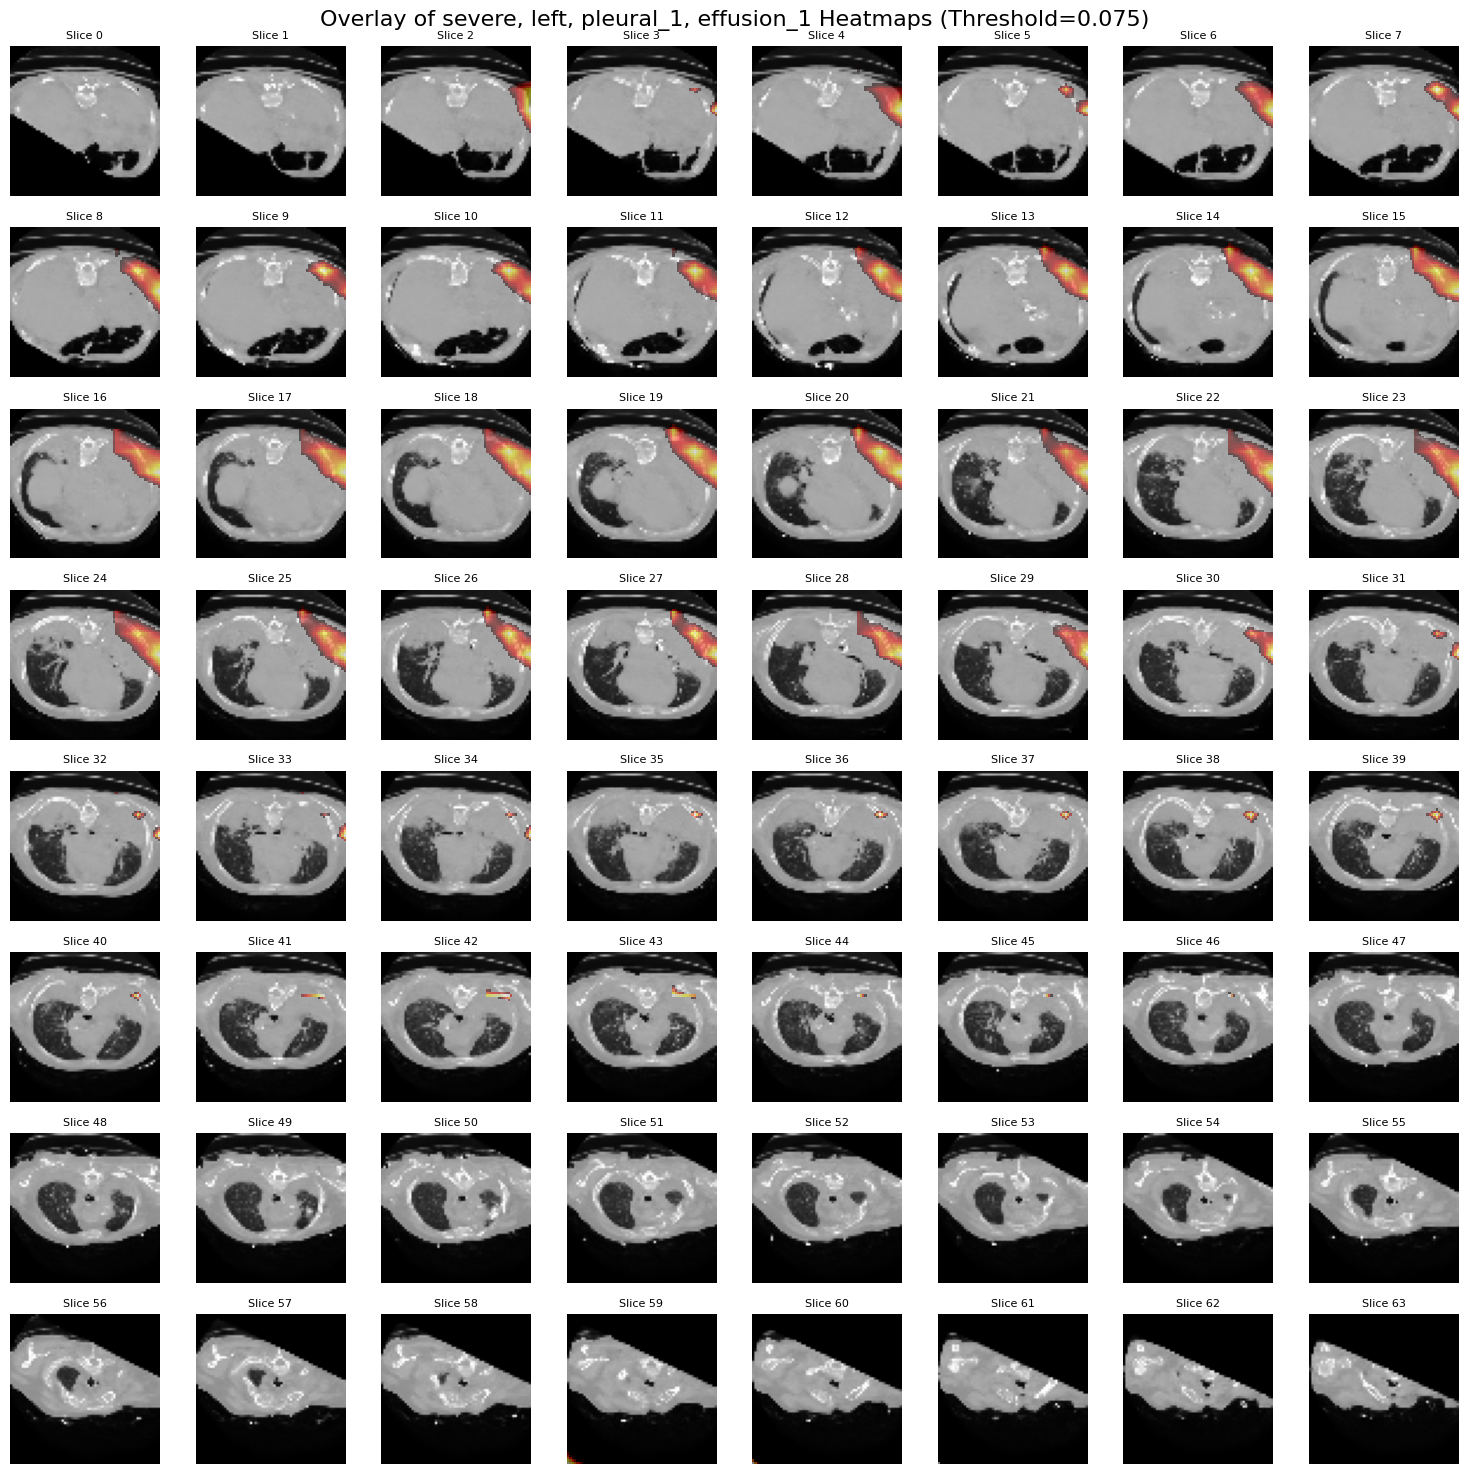

In [ ]:
#main statiic scirpt to overlay heatmaps on CT scans
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom

ct_scan_path = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/111222444/111222444_sample_0.npy"
heatmaps_folder = "/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222444/"

heatmap_files = {
    "mild": "111222444_sample_0_token_1_mild_heatmaps.npy",
    "right": "111222444_sample_0_token_2_right_heatmaps.npy",
    "pleural_1": "111222444_sample_0_token_3_pleural_heatmaps.npy",
    "effusion_1": "111222444_sample_0_token_4_effusion_heatmaps.npy",
    "severe": "111222444_sample_0_token_6_severe_heatmaps.npy",
    "left": "111222444_sample_0_token_7_left_heatmaps.npy",
    "pleural_2": "111222444_sample_0_token_8_pleural_heatmaps.npy",
    "effusion_2": "111222444_sample_0_token_9_effusion_heatmaps.npy",
}

ct_volume = np.load(ct_scan_path) 
ct_slices = ct_volume[0, 0, :, :, :] 

def resize_heatmap(heatmap, target_shape=(64, 64, 64)):
    zoom_factors = (
        target_shape[0] / heatmap.shape[0],  # Depth
        target_shape[1] / heatmap.shape[1],  # Height
        target_shape[2] / heatmap.shape[2],  # Width
    )
    return zoom(heatmap, zoom_factors, order=1)  

selected_tokens = ["severe", "left", "pleural_1", "effusion_1"]
#selected_tokens = ["right"]   
heatmap_threshold = 0.075  
selected_tokens = list(set(selected_tokens))

heatmap_stack = []
valid_pixel_counts = np.zeros((64, 64, 64))  # Count valid pixels to avoid spreading noise

for token in selected_tokens:
    heatmap_path = os.path.join(heatmaps_folder, heatmap_files[token])

    if os.path.exists(heatmap_path):
        heatmap_data = np.load(heatmap_path)  # Shape: (64, 8, 8)
        resized_heatmap = resize_heatmap(heatmap_data, target_shape=(64, 64, 64))
        
        # Apply threshold to each heatmap separately before averaging
        thresholded_heatmap = np.where(resized_heatmap >= heatmap_threshold, resized_heatmap, 0)

        # Keep track of the number of valid pixels per voxel
        valid_pixel_counts += (thresholded_heatmap > 0).astype(np.float32)

        heatmap_stack.append(thresholded_heatmap)
    else:
        print(f"Heatmap file '{heatmap_path}' not found.")

if len(heatmap_stack) == 0:
    raise ValueError("No valid heatmaps selected.")

sum_heatmap = np.sum(np.stack(heatmap_stack, axis=0), axis=0)

avg_heatmap = np.where(valid_pixel_counts > 0, sum_heatmap / valid_pixel_counts, 0)

def overlay_binary_heatmap_on_ct(ct_scan, heatmap, title):
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(64):
        ct_slice_norm = (ct_scan[i, :, :] - np.min(ct_scan[i, :, :])) / (
            np.max(ct_scan[i, :, :]) - np.min(ct_scan[i, :, :]) + 1e-8
        )  

        heatmap_slice = heatmap[i, :, :]  

        axes[i].imshow(ct_slice_norm, cmap="gray")  
        if np.any(heatmap_slice > 0):  
            heatmap_masked_slice = np.ma.masked_where(heatmap_slice <= 0, heatmap_slice)
            axes[i].imshow(heatmap_masked_slice, cmap="hot", alpha=0.5, interpolation="nearest")  # set color here

        axes[i].set_title(f"Slice {i}", fontsize=8)
        axes[i].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

overlay_binary_heatmap_on_ct(
    ct_slices,
    avg_heatmap,
    title=f"Overlay of {', '.join(selected_tokens)} Heatmaps (Threshold={heatmap_threshold})"
)


In [ ]:
# GFI gerneration of video
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import cv2
from scipy.ndimage import zoom

ct_scan_path = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/111222444/111222444_sample_0.npy"
heatmaps_folder = "/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222444/"
heatmap_files = {
    "mild": "111222444_sample_0_token_1_mild_heatmaps.npy",
    "right": "111222444_sample_0_token_2_right_heatmaps.npy",
    "pleural_1": "111222444_sample_0_token_3_pleural_heatmaps.npy",
    "effusion_1": "111222444_sample_0_token_4_effusion_heatmaps.npy",
    "severe": "111222444_sample_0_token_6_severe_heatmaps.npy",
    "left": "111222444_sample_0_token_7_left_heatmaps.npy",
    "pleural_2": "111222444_sample_0_token_8_pleural_heatmaps.npy",
    "effusion_2": "111222444_sample_0_token_9_effusion_heatmaps.npy",
}

ct_volume = np.load(ct_scan_path)
ct_slices = ct_volume[0, 0, :, :, :]  # Shape: (64, 64, 64)

def resize_heatmap(heatmap, target_shape=(64, 64, 64)):
    zoom_factors = (
        target_shape[0] / heatmap.shape[0],  # Depth
        target_shape[1] / heatmap.shape[1],  # Height
        target_shape[2] / heatmap.shape[2],  # Width
    )
    return zoom(heatmap, zoom_factors, order=1)

selected_tokens = ["severe", "left", "pleural_1", "effusion_1"]
heatmap_threshold = 0.075  
selected_tokens = list(set(selected_tokens))

heatmap_stack = []
valid_pixel_counts = np.zeros((64, 64, 64))

for token in selected_tokens:
    heatmap_path = os.path.join(heatmaps_folder, heatmap_files[token])
    if os.path.exists(heatmap_path):
        heatmap_data = np.load(heatmap_path)
        resized_heatmap = resize_heatmap(heatmap_data, target_shape=(64, 64, 64))
        thresholded_heatmap = np.where(resized_heatmap >= heatmap_threshold, resized_heatmap, 0)
        valid_pixel_counts += (thresholded_heatmap > 0).astype(np.float32)
        heatmap_stack.append(thresholded_heatmap)
    else:
        print(f"Heatmap file '{heatmap_path}' not found.")

if len(heatmap_stack) == 0:
    raise ValueError("No valid heatmaps selected.")

sum_heatmap = np.sum(np.stack(heatmap_stack, axis=0), axis=0)
avg_heatmap = np.where(valid_pixel_counts > 0, sum_heatmap / valid_pixel_counts, 0)

# Video settings
video_filename = "ct_heatmap_overlay.mp4"
fps = 5  # Frames per second
frame_size = (512, 512)  # Resize for better visualization

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter(video_filename, fourcc, fps, frame_size)

# Generate video frames
for i in range(64):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.axis("off")
    ct_slice_norm = (ct_slices[i, :, :] - np.min(ct_slices[i, :, :])) / (
        np.max(ct_slices[i, :, :]) - np.min(ct_slices[i, :, :]) + 1e-8
    )
    ax.imshow(ct_slice_norm, cmap="gray")
    heatmap_slice = avg_heatmap[i, :, :]
    if np.any(heatmap_slice > 0):
        heatmap_masked_slice = np.ma.masked_where(heatmap_slice <= 0, heatmap_slice)
        ax.imshow(heatmap_masked_slice, cmap="Reds", alpha=0.5, interpolation="nearest")

    ax.set_title(f"Slice {i}")
    plt.tight_layout()
    plt.savefig("temp_frame.png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    frame = cv2.imread("temp_frame.png")
    frame = cv2.resize(frame, frame_size)
    video_out.write(frame)

# Release video writer and clean up
video_out.release()
os.remove("temp_frame.png")

print(f"Video saved as {video_filename}")


/tmp/ipykernel_4717/463718838.py:62: RuntimeWarning: invalid value encountered in divide
  avg_heatmap = np.where(valid_pixel_counts > 0, sum_heatmap / valid_pixel_counts, 0)


Video saved as ct_heatmap_overlay.mp4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy.ndimage import zoom

ct_scan_path = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/111222444/111222444_sample_0.npy"
heatmaps_folder = "/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/111222444/"

heatmap_files = {
    "mild": "111222444_sample_0_token_1_mild_heatmaps.npy",
    "right": "111222444_sample_0_token_2_right_heatmaps.npy",
    "pleural_1": "111222444_sample_0_token_3_pleural_heatmaps.npy",
    "effusion_1": "111222444_sample_0_token_4_effusion_heatmaps.npy",
    "severe": "111222444_sample_0_token_6_severe_heatmaps.npy",
    "left": "111222444_sample_0_token_7_left_heatmaps.npy",
    "pleural_2": "111222444_sample_0_token_8_pleural_heatmaps.npy",
    "effusion_2": "111222444_sample_0_token_9_effusion_heatmaps.npy",
}

ct_volume = np.load(ct_scan_path)
ct_slices = ct_volume[0, 0, :, :, :]  # Shape: (64, 64, 64)

def resize_heatmap(heatmap, target_shape=(64, 64, 64)):
    zoom_factors = (
        target_shape[0] / heatmap.shape[0],  # Depth
        target_shape[1] / heatmap.shape[1],  # Height
        target_shape[2] / heatmap.shape[2],  # Width
    )
    return zoom(heatmap, zoom_factors, order=1)

selected_tokens = ["right"]
# selected_tokens = ["severe", "left", "pleural_1", "effusion_1"]
heatmap_threshold = 0.075  
selected_tokens = list(set(selected_tokens))

heatmap_stack = []
valid_pixel_counts = np.zeros((64, 64, 64))

for token in selected_tokens:
    heatmap_path = os.path.join(heatmaps_folder, heatmap_files[token])
    if os.path.exists(heatmap_path):
        heatmap_data = np.load(heatmap_path)
        resized_heatmap = resize_heatmap(heatmap_data, target_shape=(64, 64, 64))
        thresholded_heatmap = np.where(resized_heatmap >= heatmap_threshold, resized_heatmap, 0)
        valid_pixel_counts += (thresholded_heatmap > 0).astype(np.float32)
        heatmap_stack.append(thresholded_heatmap)
    else:
        print(f"Heatmap file '{heatmap_path}' not found.")

if len(heatmap_stack) == 0:
    raise ValueError("No valid heatmaps selected.")

sum_heatmap = np.sum(np.stack(heatmap_stack, axis=0), axis=0)
avg_heatmap = np.where(valid_pixel_counts > 0, sum_heatmap / valid_pixel_counts, 0)

video_filename = "ct_heatmap_overlay_256_Red_right.mp4"
fps = 5  # Frames per second
output_resolution = (256, 256)  # Bilinear interpolation to 256x256
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter(video_filename, fourcc, fps, output_resolution)

for i in range(64):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.axis("off")

    ct_slice_norm = (ct_slices[i, :, :] - np.min(ct_slices[i, :, :])) / (
        np.max(ct_slices[i, :, :]) - np.min(ct_slices[i, :, :]) + 1e-8
    )
    ax.imshow(ct_slice_norm, cmap="gray")
    heatmap_slice = avg_heatmap[i, :, :]
    if np.any(heatmap_slice > 0):
        heatmap_masked_slice = np.ma.masked_where(heatmap_slice <= 0, heatmap_slice)
        ax.imshow(heatmap_masked_slice, cmap="Reds", alpha=0.5, interpolation="nearest")

    ax.set_title(f"Slice {i}")

    plt.tight_layout()
    plt.savefig("temp_frame.png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    frame = cv2.imread("temp_frame.png")
    frame = cv2.resize(frame, output_resolution, interpolation=cv2.INTER_LINEAR)
    video_out.write(frame)
video_out.release()
os.remove("temp_frame.png")

print(f"Video saved as {video_filename}")


/tmp/ipykernel_4717/54333247.py:61: RuntimeWarning: invalid value encountered in divide
  avg_heatmap = np.where(valid_pixel_counts > 0, sum_heatmap / valid_pixel_counts, 0)


Video saved as ct_heatmap_overlay_256_Red_right.mp4
